Today (day 9 and 10), we're doing MLE (Maximum Likelihood Estimation). Basically, trying to "predict" by computing probabilities to get estimations of OU parameters. (we'll use log to compute rly small numbers on the pc). We'll use the probability (density) of X+1 when we're at X (transition density).

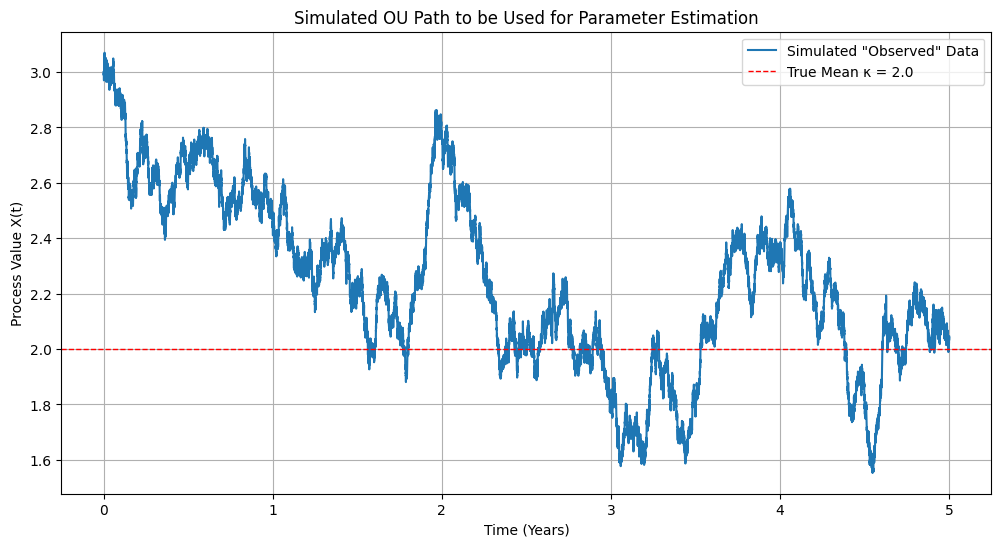


Starting Maximum Likelihood Estimation...
Initial Guess: [2.5, np.float64(2.2410550922468517), np.float64(0.31408850035695085)]

Optimization Successful!
Estimated Theta: 2.4978 (True: 3.0)
Estimated Kappa: 2.1643 (True: 2.0)
Estimated Sigma: 0.5990 (True: 0.6)

Optimization Successful!
Estimated Theta: 2.4978 (True: 3.0)
Estimated Kappa: 2.1642 (True: 2.0)
Estimated Sigma: 0.5989 (True: 0.6)


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import sys, os
import time

notebook_dir = os.path.dirname(os.path.abspath("__file__")) 
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from estimation import ou_neg_log_likelihood, ou_neg_log_likelihood_approx
from sde_simulator.simulators import simulate_ou_em_vectorized

#imports above

#secret parameters here, we'll need to find those basically by computing the probabilities etc
THETA_TRUE = 3.0    #true speed of reversion
KAPPA_TRUE = 2.0    #true long-term mean
SIGMA_TRUE = 0.6    #true volatility
X0_TRUE = 3.0       #true initial value

#normal settings that can be found by reading graph data directly
T_DATA = 5.0        #simulate for 5 years
DT_DATA = 0.0001      #use a reasonably small dt
NUM_PATHS_DATA = 1  #we only need one path

#simulate with our variables
t_data, X_data_paths = simulate_ou_em_vectorized(
    X0_TRUE, THETA_TRUE, KAPPA_TRUE, SIGMA_TRUE, 
    T_DATA, DT_DATA, NUM_PATHS_DATA
)

observed_data = X_data_paths[:, 0] 
time_points_data = t_data

plt.figure(figsize=(12, 6))
plt.plot(time_points_data, observed_data, lw=1.5, label='Simulated "Observed" Data')
plt.axhline(KAPPA_TRUE, color='red', linestyle='--', lw=1, label=f'True Mean κ = {KAPPA_TRUE}')
plt.title('Simulated OU Path to be Used for Parameter Estimation')
plt.xlabel('Time (Years)')
plt.ylabel('Process Value X(t)')
plt.legend()
plt.grid(True)
plt.show()



print("\nStarting Maximum Likelihood Estimation...")

#initial guess for parameters [theta, kappa, sigma]
#can start near true values, or use reasonable defaults like [1.0, np.mean(data), np.std(data)]
#initial_guess = [THETA_TRUE, KAPPA_TRUE, SIGMA_TRUE] 
initial_guess = [2.5, np.mean(observed_data), np.std(observed_data)] 
print(f"Initial Guess: {initial_guess}")

#bounds for parameters (theta > 0, kappa can be anything, sigma > 0)
#add a small epsilon to lower bound to avoid zero exactly
bounds = [(1e-6, None), (None, None), (1e-6, None)] 

#run the minimizer
#method 'L-BFGS-B' is good for bound constraints
result = minimize(
    fun=ou_neg_log_likelihood, 
    x0=initial_guess, 
    args=(observed_data, DT_DATA), #pass data and dt as extra arguments
    method='L-BFGS-B', 
    bounds=bounds
)

#check if optimization was successful
if result.success:
    estimated_params = result.x
    print("\nOptimization Successful!")
    print(f"Estimated Theta: {estimated_params[0]:.4f} (True: {THETA_TRUE})")
    print(f"Estimated Kappa: {estimated_params[1]:.4f} (True: {KAPPA_TRUE})")
    print(f"Estimated Sigma: {estimated_params[2]:.4f} (True: {SIGMA_TRUE})")
else:
    print("\nOptimization Failed!")
    print(result.message)

#again but with approx function bcs we have bad approximations
result = minimize(
    fun=ou_neg_log_likelihood_approx, 
    x0=initial_guess, 
    args=(observed_data, DT_DATA), #pass data and dt as extra arguments
    method='L-BFGS-B', 
    bounds=bounds
)

#check if optimization was successful
if result.success:
    estimated_params = result.x
    print("\nOptimization Successful!")
    print(f"Estimated Theta: {estimated_params[0]:.4f} (True: {THETA_TRUE})")
    print(f"Estimated Kappa: {estimated_params[1]:.4f} (True: {KAPPA_TRUE})")
    print(f"Estimated Sigma: {estimated_params[2]:.4f} (True: {SIGMA_TRUE})")
else:
    print("\nOptimization Failed!")
    print(result.message)